In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
import json

from scipy.stats import zscore

from sklearn.model_selection import (
    train_test_split, cross_val_score, ShuffleSplit, GridSearchCV)
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA

from catboost import CatBoostRegressor

from xgboost import XGBRegressor

In [2]:
df = pd.read_csv('/home/akeemlag/Downloads/car_price_prediction.csv')

## EXPLORATORY ANALYSIS

In [3]:
df.head(10)

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4
5,45802912,39493,891,HYUNDAI,Santa FE,2016,Jeep,Yes,Diesel,2,160931 km,4.0,Automatic,Front,04-May,Left wheel,White,4
6,45656768,1803,761,TOYOTA,Prius,2010,Hatchback,Yes,Hybrid,1.8,258909 km,4.0,Automatic,Front,04-May,Left wheel,White,12
7,45816158,549,751,HYUNDAI,Sonata,2013,Sedan,Yes,Petrol,2.4,216118 km,4.0,Automatic,Front,04-May,Left wheel,Grey,12
8,45641395,1098,394,TOYOTA,Camry,2014,Sedan,Yes,Hybrid,2.5,398069 km,4.0,Automatic,Front,04-May,Left wheel,Black,12
9,45756839,26657,-,LEXUS,RX 350,2007,Jeep,Yes,Petrol,3.5,128500 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12


In [4]:
print(df.shape)
df.info()

(19237, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Price             19237 non-null  int64  
 2   Levy              19237 non-null  object 
 3   Manufacturer      19237 non-null  object 
 4   Model             19237 non-null  object 
 5   Prod. year        19237 non-null  int64  
 6   Category          19237 non-null  object 
 7   Leather interior  19237 non-null  object 
 8   Fuel type         19237 non-null  object 
 9   Engine volume     19237 non-null  object 
 10  Mileage           19237 non-null  object 
 11  Cylinders         19237 non-null  float64
 12  Gear box type     19237 non-null  object 
 13  Drive wheels      19237 non-null  object 
 14  Doors             19237 non-null  object 
 15  Wheel             19237 non-null  object 
 16  Color             19237 non-

In [5]:
df.duplicated().sum()

313

In [6]:
# Rename the cols for easy access
df.columns = df.columns.str.replace(' ', '_')

df.head()

,ID,Price,Levy,Manufacturer,Model,Prod._year,Category,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box_type,Drive_wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


There roughly 6000 rows with this kind of data that are not int and not null If we remove such humongous dataset, it will impact our ds training Proposition is to conver the remaining value to an int, calculate the mean per year and replace the  the - with the mean


In [7]:
def isInt(x):
    try:
        int(x)
    except:
        return None
    return int(x)

df.Mileage = df.Mileage.apply(lambda x: x.split(' ')[0])

In [8]:
# Convert Levy to int and fill out the '-' with the mean
cols_to_convert = ['Levy', 'Mileage', 'Cylinders']
for col in cols_to_convert:
    df[col] = df[col].apply(isInt)
    if df[col].isna().sum() > 0:
        df[col] = df[col].fillna(df[col].mean())
    df[col] = df[col].astype(int)

In [9]:
df.Engine_volume = df.Engine_volume.str.split(' ').str[0]
df.Engine_volume = df.Engine_volume.astype(float)

In [10]:
df.describe()/1000

,ID,Price,Levy,Prod._year,Engine_volume,Mileage,Cylinders,Airbags
count,19.237000,19.237000,19.237000,19.237000,19.237000,1.923700e+01,19.237000,19.237000
mean,45576.535886,18.555927,0.906585,2.010913,0.002308,1.532236e+03,0.004583,0.006583
std,936.591423,190.581270,0.385734,0.005669,0.000878,4.840387e+04,0.001200,0.004320
min,20746.880000,0.001000,0.087000,1.939000,0.000000,0.000000e+00,0.001000,0.000000
25%,45698.374000,5.331000,0.730000,2.009000,0.001800,7.013900e+01,0.004000,0.004000
50%,45772.308000,13.172000,0.906000,2.012000,0.002000,1.260000e+02,0.004000,0.006000
75%,45802.036000,22.075000,0.917000,2.015000,0.002500,1.888880e+02,0.004000,0.012000
max,45816.654000,26307.500000,11.714000,2.020000,0.020000,2.147484e+06,0.016000,0.016000


In [11]:
for col in df.columns:
    print(f'Unique values in {col} are: {df[col].unique()}')

Unique values in ID are: [45654403 44731507 45774419 ... 45804997 45793526 45813273]
Unique values in Price are: [13328 16621  8467 ... 56814 63886 22075]
Unique values in Levy are: [ 1399  1018   906   862   446   891   761   751   394  1053  1055  1079
   810  2386  1850   531   586  1249  2455   583  1537  1288   915  1750
   707  1077  1486  1091   650   382  1436  1194   503  1017  1104   639
   629   919   781   530   640   765   777   779   934   769   645  1185
  1324   830  1187  1111   760   642  1604  1095   966   473  1138  1811
   988   917  1156   687 11714   836  1347  2866  1646   259   609   697
   585   475   690   308  1823  1361  1273   924   584  2078   831  1172
   893  1872  1885  1266   447  2148  1730   730   289   502   333  1325
   247   879  1342  1327  1598  1514  1058   738  1935   481  1522  1282
   456   880   900   798  1277   442  1051   790  1292  1047   528  1211
  1493  1793   574   930  1998   271   706  1481  1677  1661  1286  1408
  1090   595  1

#### ::: From observation: Drop some features that serve no purpose

In [12]:
# Drop features that offer no trend or of no significant importance
# Not dropping engine vol  because this is a used car and in most business settings, that affects its resale value
# Drop the ID col and Doors cols ::: ID cols offers no value or trend, Doors col  is populated with the wrong data
# Dropping wheel col has in a real business setting, Left or ra=ight hand does not offer a significant resale value
cols_to_drop = ['ID', 'Doors', 'Wheel']
df = df.drop(cols_to_drop, axis=1)
df

,Price,Levy,Manufacturer,Model,Prod._year,Category,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box_type,Drive_wheels,Color,Airbags
0,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005,6,Automatic,4x4,Silver,12
1,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3.0,192000,6,Tiptronic,4x4,Black,8
2,8467,906,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000,4,Variator,Front,Black,2
3,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966,4,Automatic,4x4,White,0
4,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901,4,Automatic,Front,Silver,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19232,8467,906,MERCEDES-BENZ,CLK 200,1999,Coupe,Yes,CNG,2.0,300000,4,Manual,Rear,Silver,5
19233,15681,831,HYUNDAI,Sonata,2011,Sedan,Yes,Petrol,2.4,161600,4,Tiptronic,Front,Red,8
19234,26108,836,HYUNDAI,Tucson,2010,Jeep,Yes,Diesel,2.0,116365,4,Automatic,Front,Grey,4
19235,5331,1288,CHEVROLET,Captiva,2007,Jeep,Yes,Diesel,2.0,51258,4,Automatic,Front,Black,4


## ::: Visualization and Analysis

In [13]:
# Check if any cols contain values that are non int in the numerical cols
numerical_cols = df.select_dtypes(include=['int', 'float']).columns
print('numerical_cols: ', numerical_cols)
categorical_cols = df.select_dtypes(include=['object']).columns
print('categorical_cols: ',categorical_cols)

numerical_cols:  Index(['Price', 'Levy', 'Prod._year', 'Engine_volume', 'Mileage', 'Cylinders',
       'Airbags'],
      dtype='object')
categorical_cols:  Index(['Manufacturer', 'Model', 'Category', 'Leather_interior', 'Fuel_type',
       'Gear_box_type', 'Drive_wheels', 'Color'],
      dtype='object')


#### Let's handle outliers

##### We are handling outliers first so that we do not get false interpretation in our analysis or to avoid plotting it twice(before or after)

#### Before using IQR to remove analysis

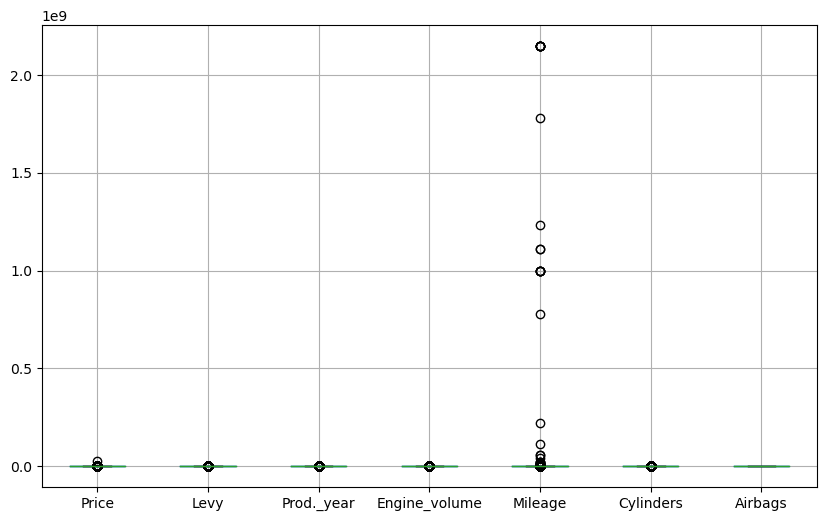

In [14]:
#Create a boc plot to visualize outliers in the numerical cols
numerical_data = df.select_dtypes(exclude=object)
numerical_data
cols = [col for col in numerical_data]
numerical_data.boxplot(figsize=(10,6), column=cols)
plt.show();

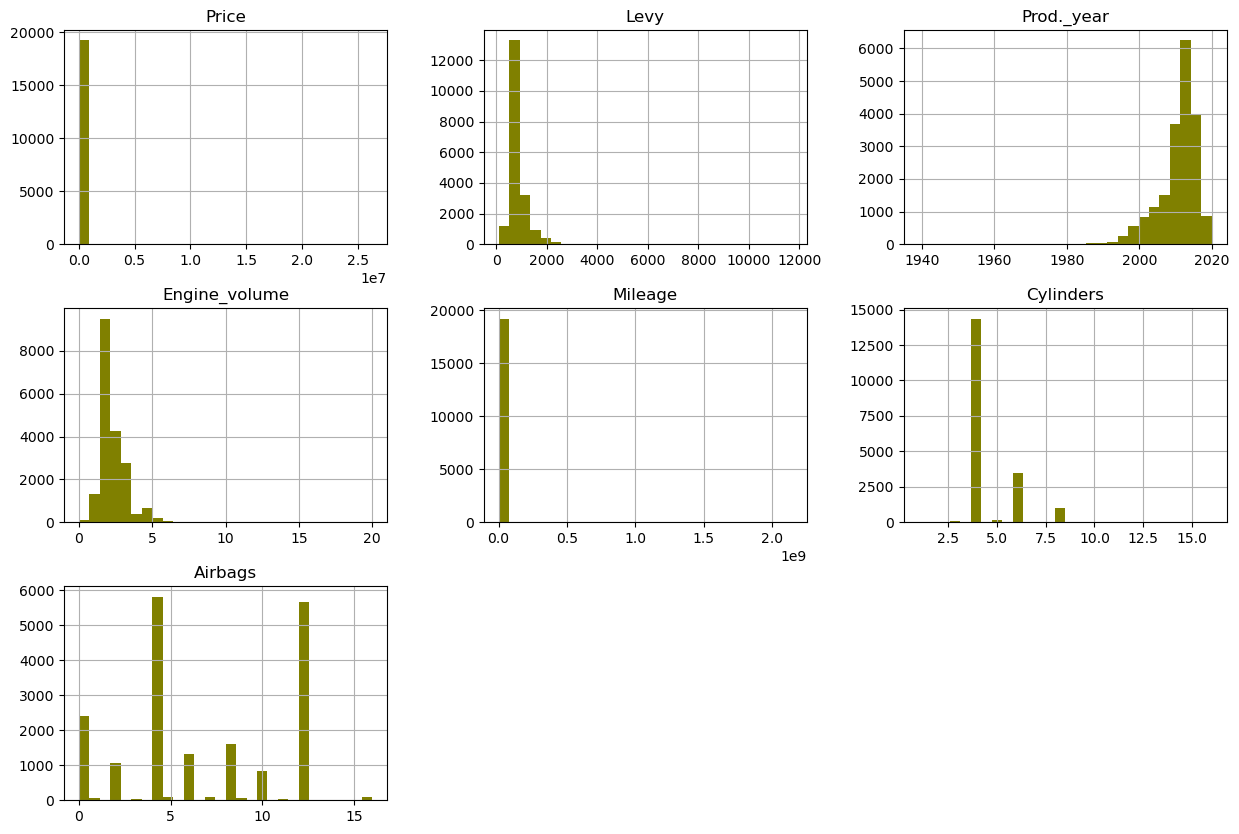

In [15]:
df.hist(bins = 28, figsize=(15, 10), color ='olive')
plt.show();

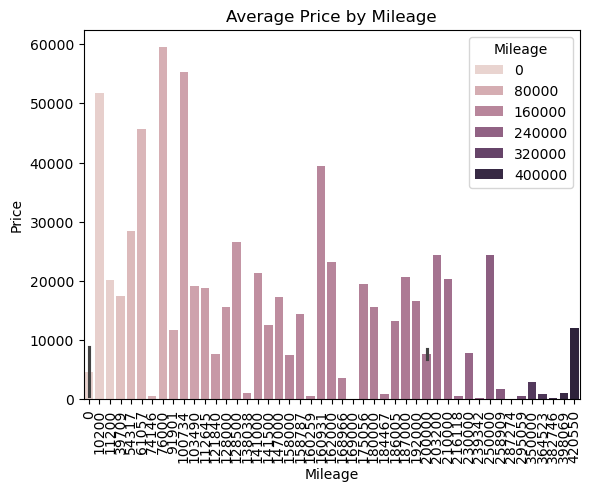

In [16]:
sns.barplot(x='Mileage', y='Price', data=df.iloc[:50], estimator="mean", hue='Mileage')
plt.title('Average Price by Mileage')
plt.xticks(rotation=90)
plt.show();

##### From the above graph, it translates to the one thing, most values in the 0 region shows that they have low price, meaning the 0 was an input error most likely or a faulty vehicle

| Cause | Solution | 
|---- | ----|
| Faulty Car | Find outliers and reassign |
| Input error | Find outliers and remove |


From the above, it is an input error because f we re-assign its values to the lower limit, then it will translates to low mileage is equal to low price which is not the case in a real world scenario. The hgher the mileage, the lower the price

In [17]:
#Using scipy.stats.zscore
def remove_outliers_zscore(df, col_name):
    zscore_name = f'zscore_{col_name}'
    df[zscore_name] = np.abs(zscore(df[col_name]))
    df = df[df[zscore_name] < 3]
    return df[col_name].sort_values(ascending=True).reset_index()

In [18]:
def get_and_remove_outliers(col, df):
    # Define the thresholds (10th and 90th percentiles in this case)
    lower_limit, upper_limit = df[col].quantile([0.05, 0.95])
    
    print(f'Upper limit: {upper_limit}')
    print(f'Lower limit: {lower_limit}')
    
    # Filter the DataFrame to remove outliers
    outliers = df[(df[col] <= upper_limit) & (df[col] >= lower_limit)]
    print(f'There are {outliers.shape[0]} outliers')

    return outliers

In [19]:
df = get_and_remove_outliers('Mileage', df)

Upper limit: 320000.0
Lower limit: 2313.200000000008
There are 17317 outliers


In [20]:
df = get_and_remove_outliers('Price', df=df)

Upper limit: 50178.0
Lower limit: 314.0
There are 15692 outliers


In [21]:
df = get_and_remove_outliers('Engine_volume', df=df)

Upper limit: 3.7
Lower limit: 1.4
There are 14253 outliers


In [22]:
df = get_and_remove_outliers('Levy', df=df)

Upper limit: 1327.0
Lower limit: 481.0
There are 12850 outliers


In [23]:
def get_and_reassign_outliers_q(col_name, df):
    # Use quantile to reassign outliers
    lower_limit, upper_limit = df[col_name].quantile([0.1, 0.9])

    print(f'upper_limit: ', {upper_limit})
    print(f'lower_limit: ', {lower_limit})
    outliers = df[(df[col_name] > upper_limit) | (df[col_name] < lower_limit)]
    print(f'There are {outliers.shape[0]} outliers')
    df[col_name] = np.where(df[col_name] < lower_limit, lower_limit, df[col_name])
    df[col_name] = np.where(df[col_name] > upper_limit, upper_limit, df[col_name])
    
    return df[col_name].sort_values(ascending=True).reset_index()

In [24]:
def get_and_remove_outliers_iqr(col, df):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    print(f'Upper limit: {upper_limit}')
    print(f'Lower limit: {lower_limit}')
    
    # Filter the DataFrame to remove outliers
    df = df[(df[col] <= upper_limit) & (df[col] >= lower_limit)]

    return df[col].sort_values(ascending=True).reset_index()    

#### After using Quantile to remove analysis

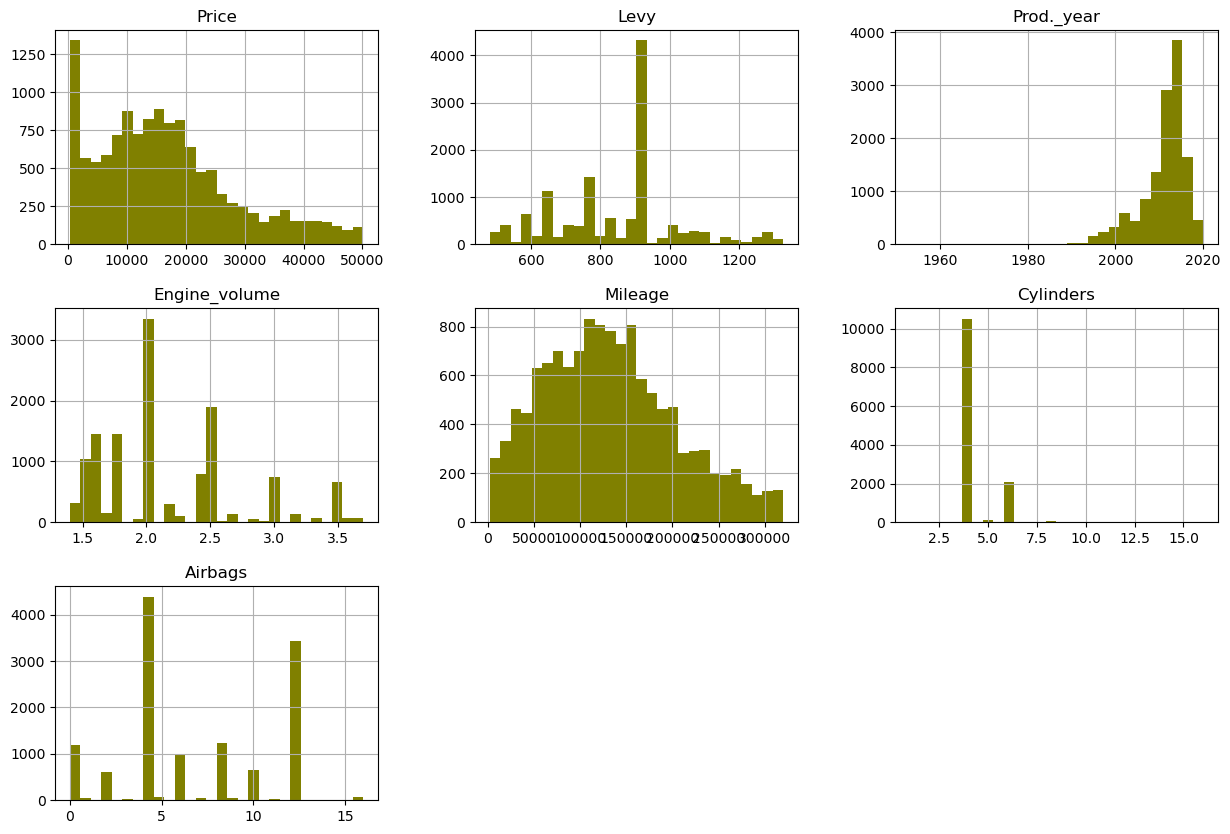

In [25]:
df.hist(bins = 28, figsize=(15, 10), color ='olive')
plt.show();

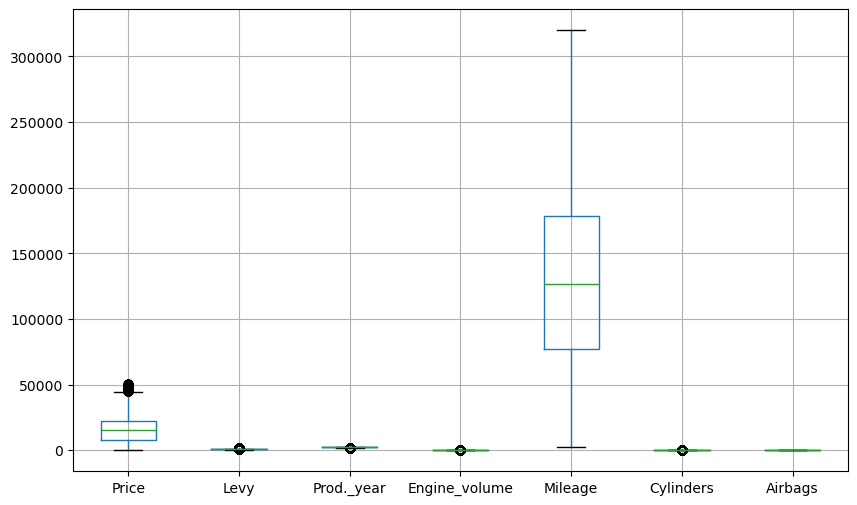

In [26]:
numerical_data = df.select_dtypes(exclude=object)
numerical_data
cols = [col for col in numerical_data]
numerical_data.boxplot(figsize=(10,6), column=cols)
plt.show();

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12850 entries, 1 to 19236
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             12850 non-null  int64  
 1   Levy              12850 non-null  int64  
 2   Manufacturer      12850 non-null  object 
 3   Model             12850 non-null  object 
 4   Prod._year        12850 non-null  int64  
 5   Category          12850 non-null  object 
 6   Leather_interior  12850 non-null  object 
 7   Fuel_type         12850 non-null  object 
 8   Engine_volume     12850 non-null  float64
 9   Mileage           12850 non-null  int64  
 10  Cylinders         12850 non-null  int64  
 11  Gear_box_type     12850 non-null  object 
 12  Drive_wheels      12850 non-null  object 
 13  Color             12850 non-null  object 
 14  Airbags           12850 non-null  int64  
dtypes: float64(1), int64(6), object(8)
memory usage: 1.6+ MB


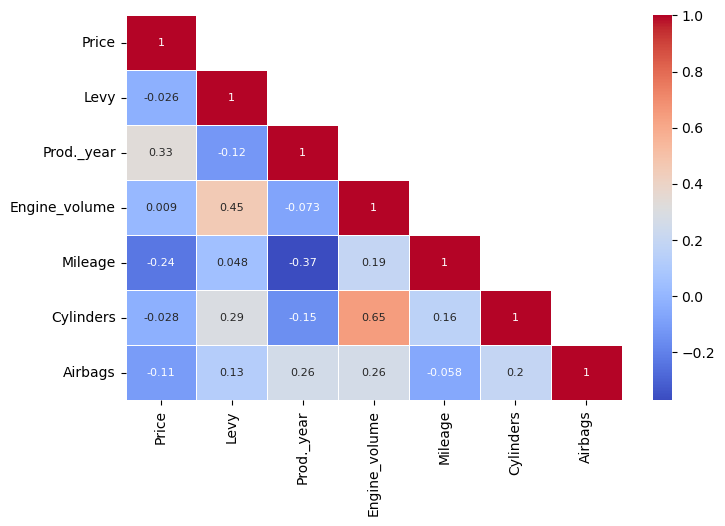

In [28]:
# Corr between numerical cols
corr = df[numerical_cols].corr()
# Remove repetition
plt.figure(figsize=(8,5))
mask = ~np.tri(corr.shape[0], k=0, dtype=bool)

sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', linewidths=0.5, annot_kws={'size': 8});
plt.show();

#### Categorical features visualization for understanding and distribution

<Figure size 2000x1000 with 0 Axes>

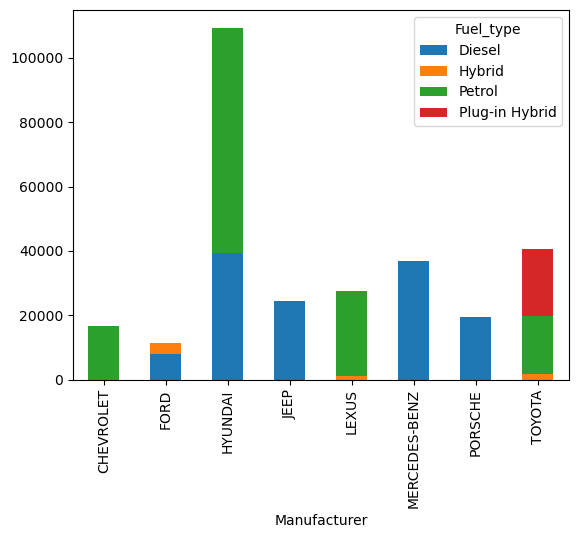

In [29]:
plt.figure(figsize=(20,10))
group_df = df.copy()
group_df = group_df.iloc[:20]
pivot_df = group_df.pivot_table(index='Manufacturer', columns='Fuel_type', values='Price', aggfunc='sum')

# Plotting the stacked bar plot
pivot_df.plot(kind='bar', stacked=True)
plt.show();

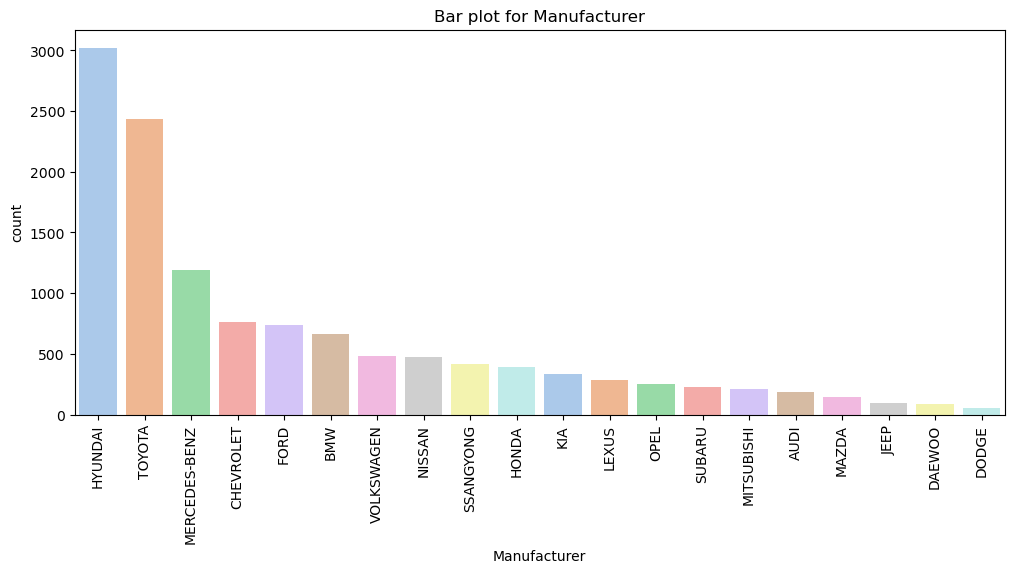

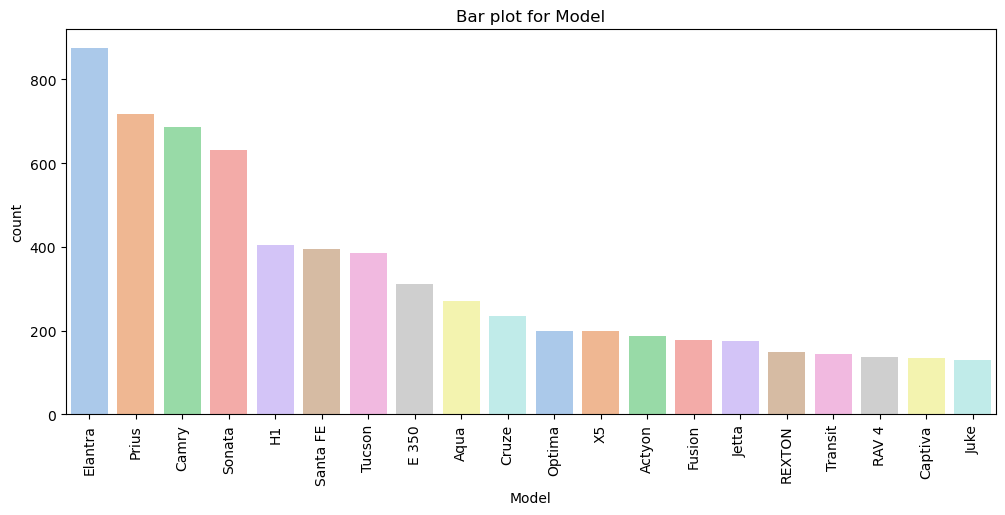

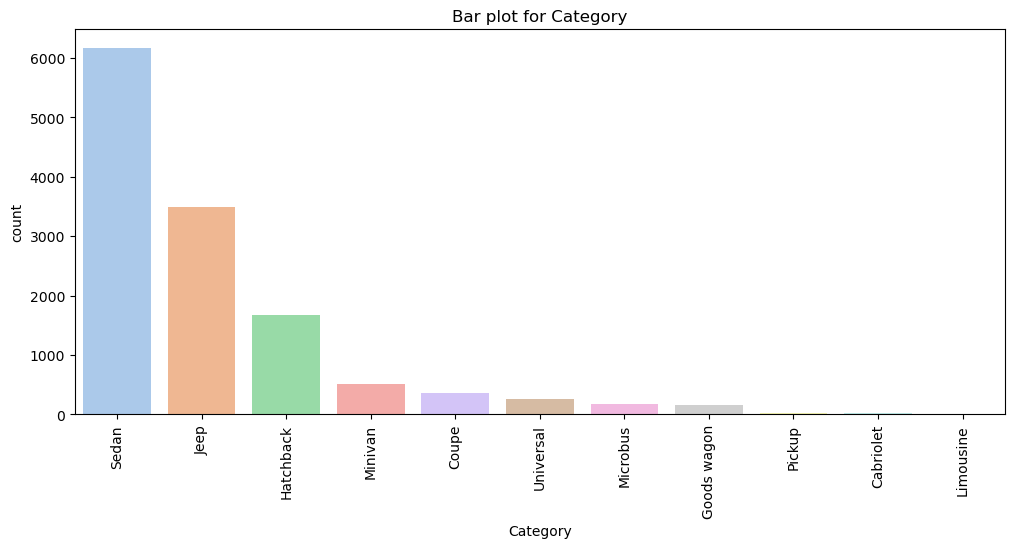

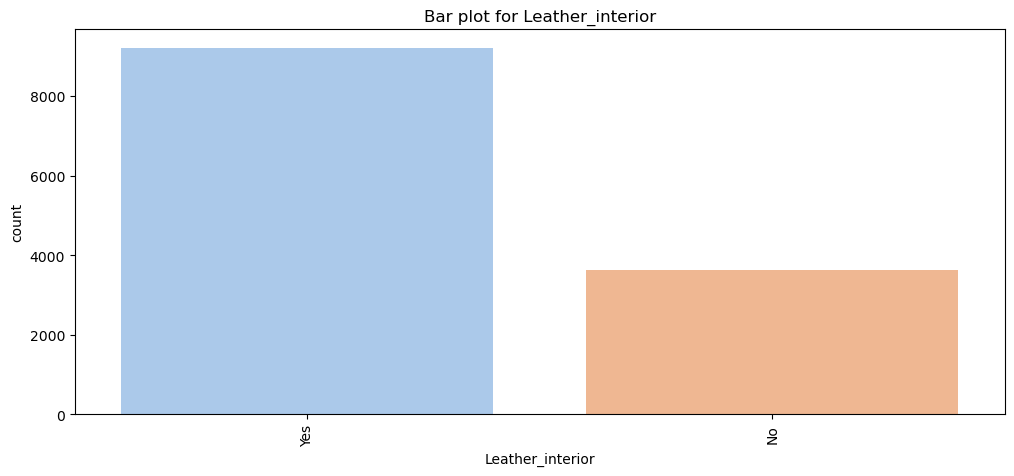

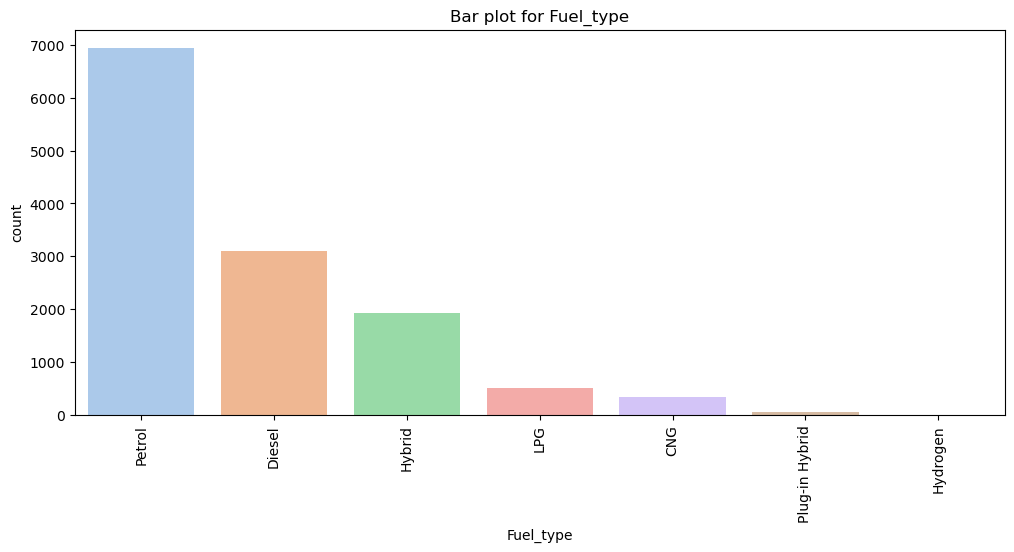

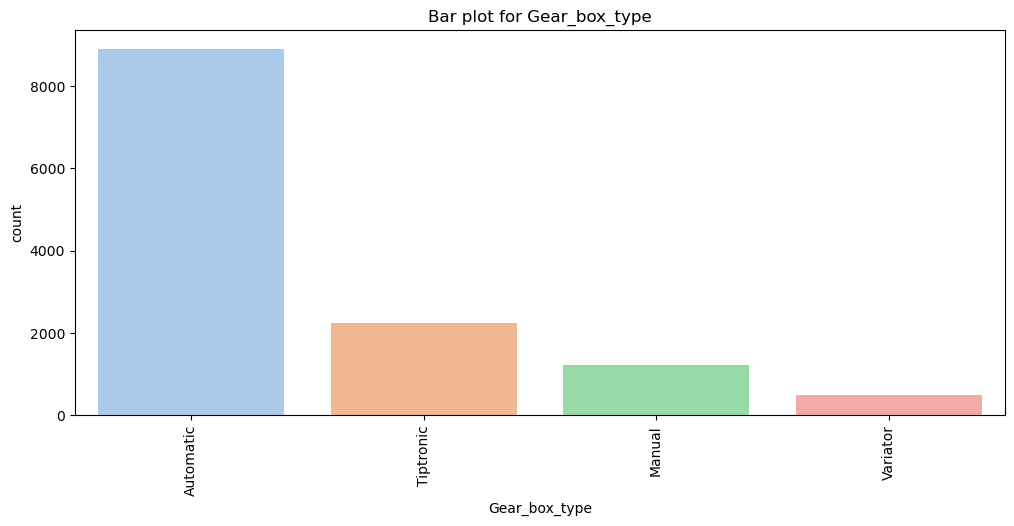

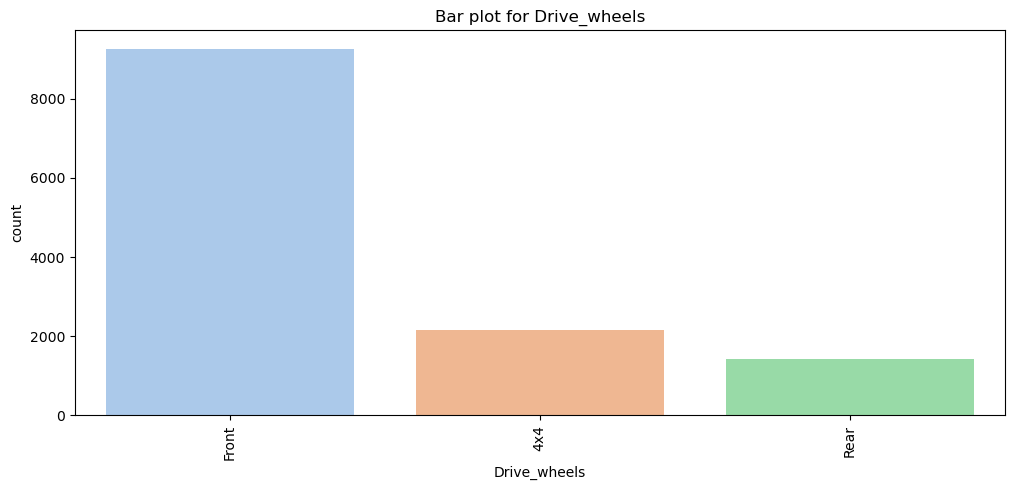

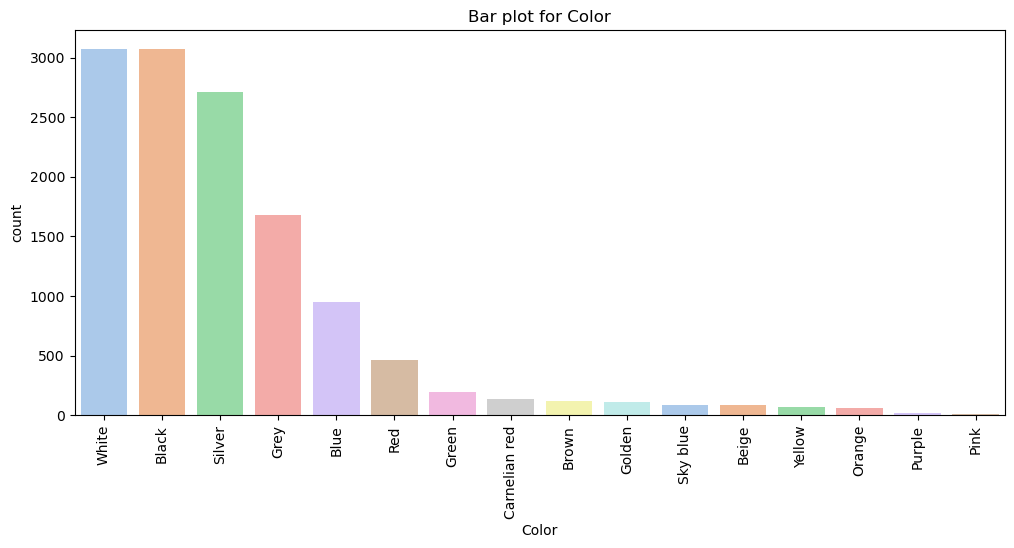

In [30]:
# create a function to draw a barplot for all categorical features
def plot_cat_barplot():
    for cols in categorical_cols:
        plt.figure(figsize=(12,5))
        value = df[cols].value_counts(ascending=False).reset_index()[:20]
        sns.barplot(x=cols, y='count', data=value, hue=cols, palette='pastel')
        plt.xticks(rotation=90)
        plt.title(f'Bar plot for {cols}')
        plt.show();
    
plot_cat_barplot()

Analysis if there is a relationship between some categorical features and prices e.g Leather interior

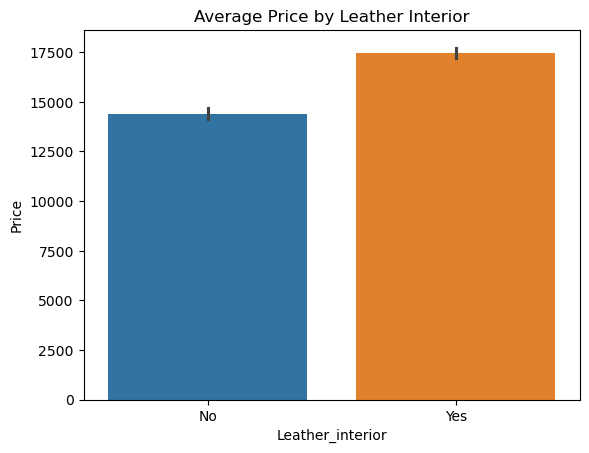

In [31]:
sns.barplot(x='Leather_interior', y='Price', data=df, estimator="mean", hue='Leather_interior')
plt.title('Average Price by Leather Interior')
plt.show();

##### Leather interior has a slight impact on the price than non-leather

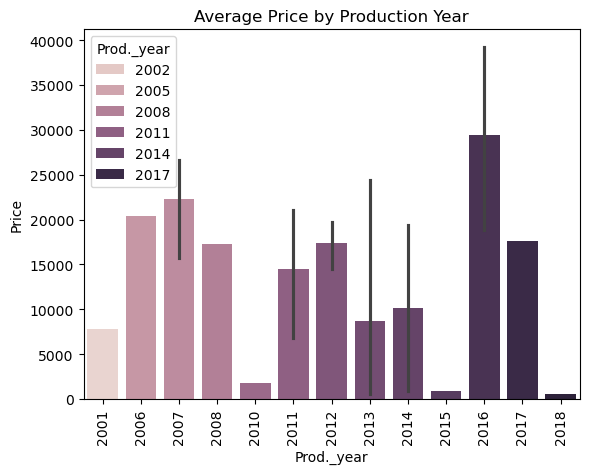

In [32]:

sns.barplot(x='Prod._year', y='Price', data=df.iloc[:30], estimator="mean", hue='Prod._year')
plt.title('Average Price by Production Year')
plt.xticks(rotation=90)
plt.show();

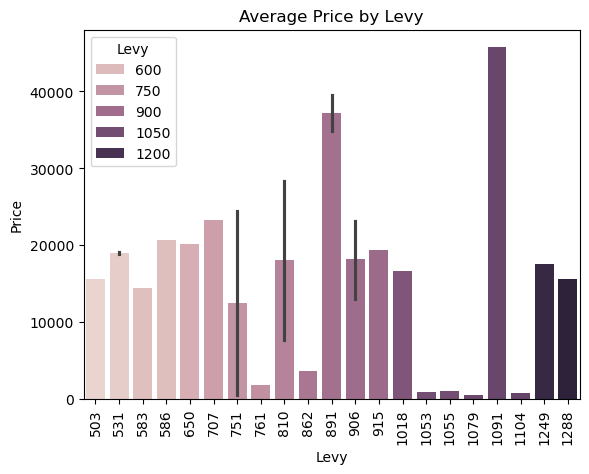

In [33]:
sns.barplot(x='Levy', y='Price', data=df.iloc[:30], estimator="mean", hue='Levy')
plt.title('Average Price by Levy')
plt.xticks(rotation=90)
plt.show();

##### Advancement in Year does not have a significant impact on the in price

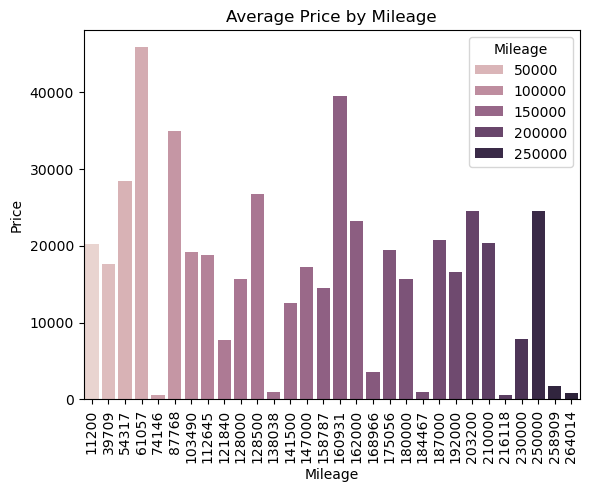

In [34]:
sns.barplot(x='Mileage', y='Price', data=df.iloc[:30], estimator="mean", hue='Mileage')
plt.title('Average Price by Mileage')
plt.xticks(rotation=90)
plt.show();

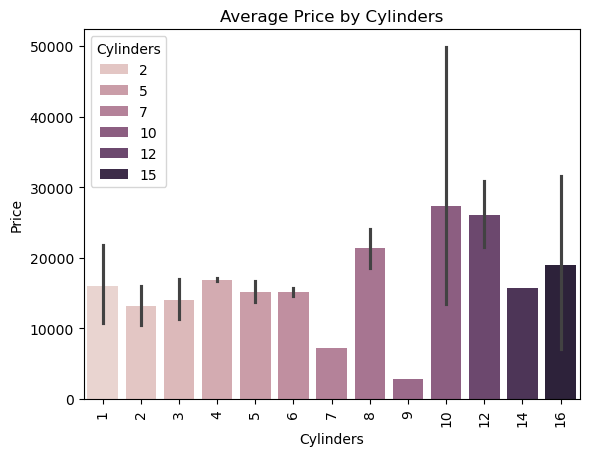

In [35]:
# grouped_df = df.groupby('Cylinders')['Price'].mean()
# sorted_order = grouped_df.sort_values(ascending=False).index

sns.barplot(x='Cylinders', y='Price', data=df, estimator="mean", hue='Cylinders')
plt.title('Average Price by Cylinders')
plt.xticks(rotation=90);
plt.show();

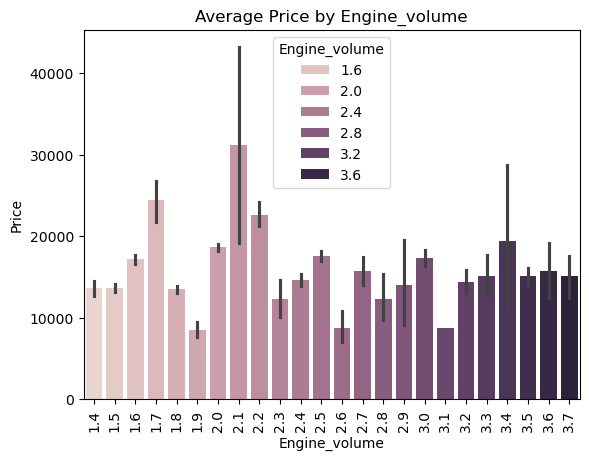

In [36]:
# grouped_df = df.groupby('Engine_volume')['Price'].mean()
# sorted_order = grouped_df.sort_values(ascending=False).index

sns.barplot(x='Engine_volume', y='Price', data=df, estimator=np.mean, hue='Engine_volume')
plt.title('Average Price by Engine_volume')
plt.xticks(rotation=90);
plt.show();

##### There is no sig of mileage to increase in price

#### Analysiing the impact of some categorical features on the Price

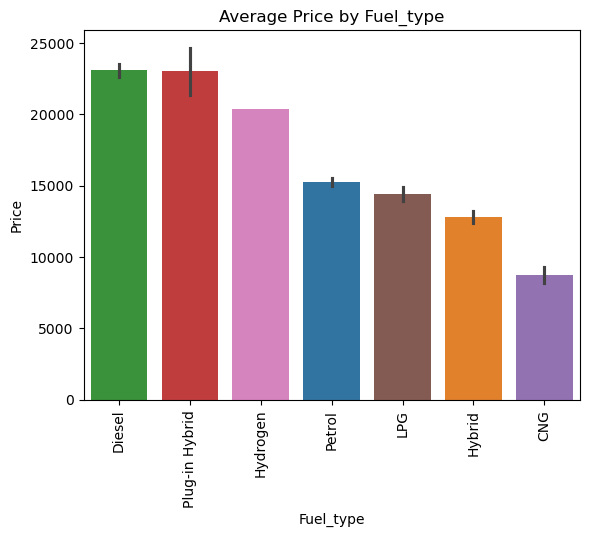

In [37]:
grouped_df = df.groupby('Fuel_type')['Price'].mean()
sorted_order = grouped_df.sort_values(ascending=False).index

sns.barplot(x='Fuel_type', y='Price', data=df, estimator=np.mean, hue='Fuel_type', order=sorted_order)
plt.title('Average Price by Fuel_type')
plt.xticks(rotation=90);
plt.show();

##### It shows that diesel and plug-in hybrid has the highest mean price

The probability that a diesel car will have higher price compared to a CNG car is high

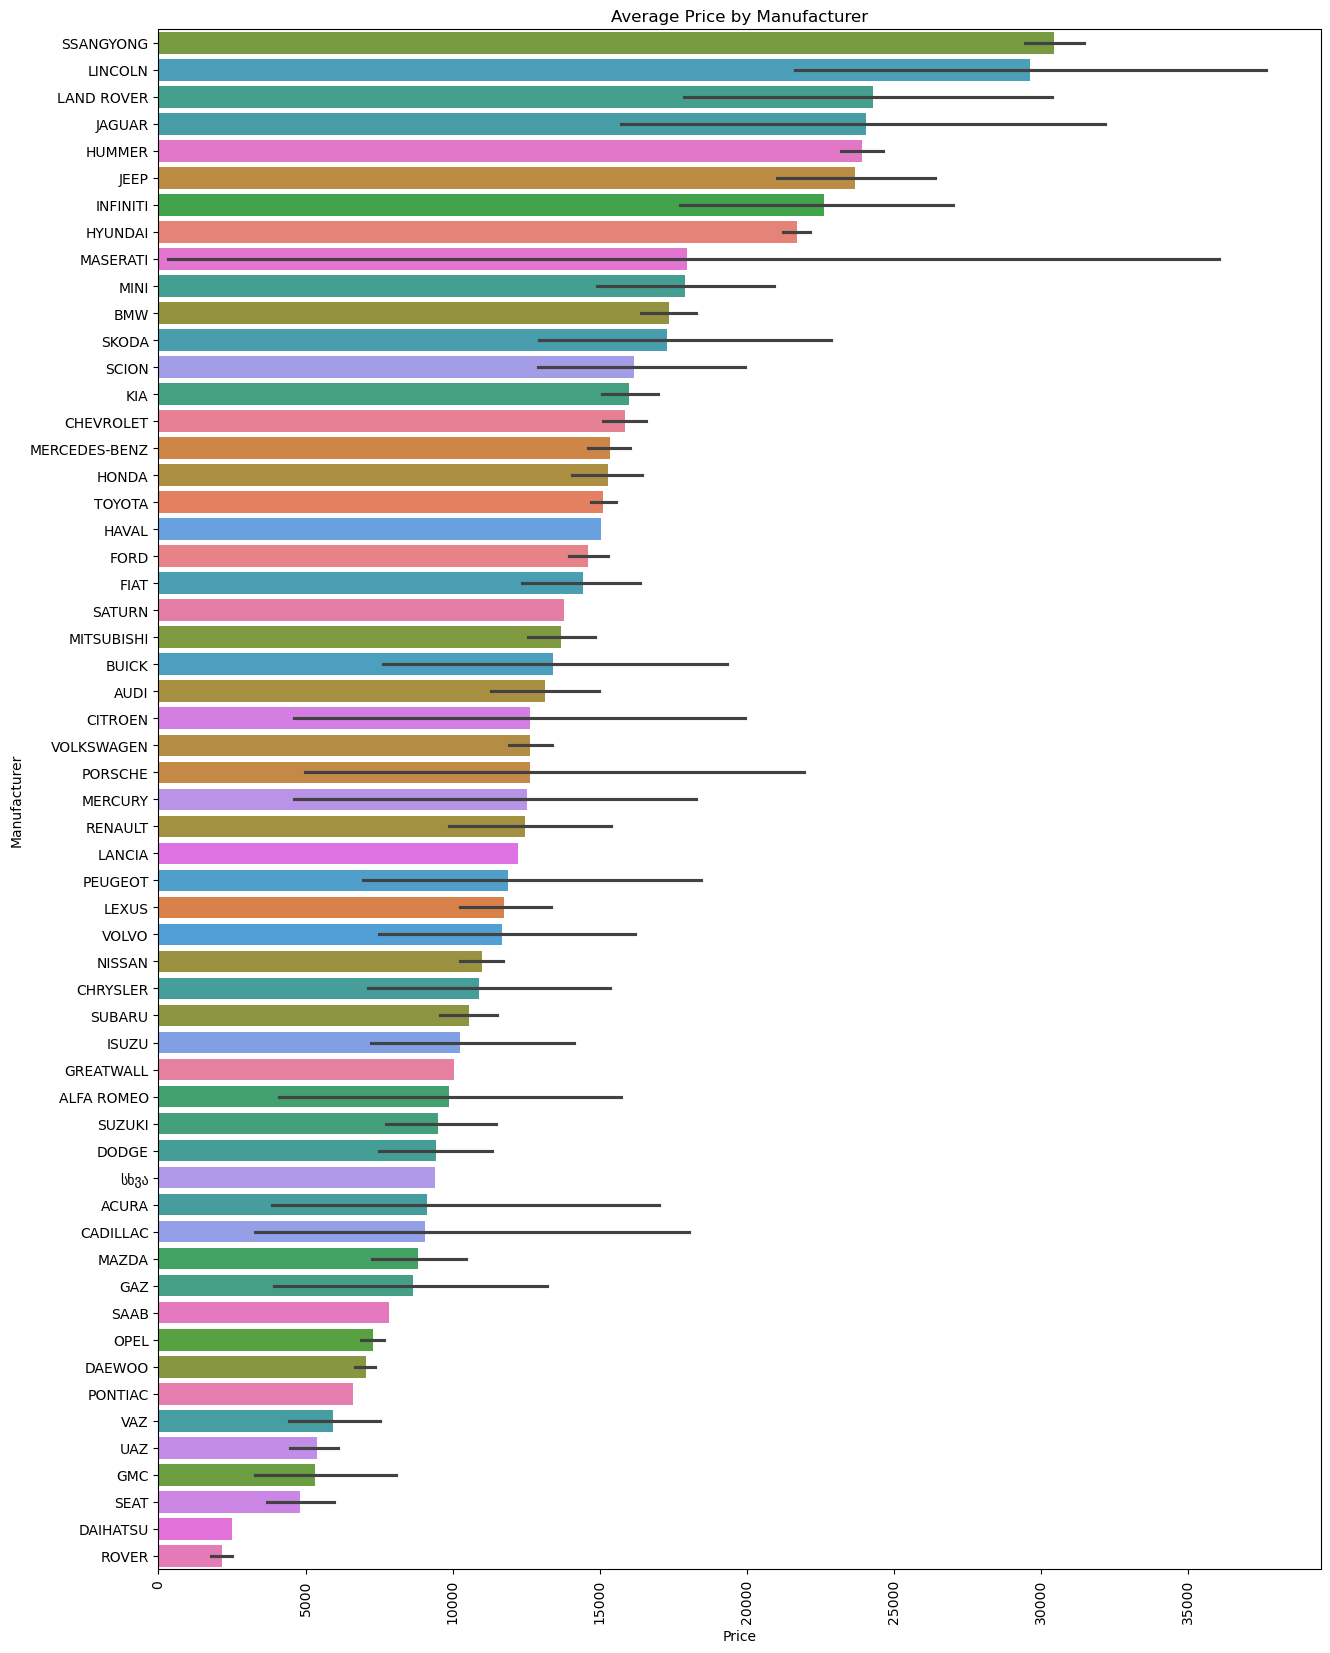

In [38]:
df_subset = df.iloc[:30]
grouped_df = df.groupby('Manufacturer')['Price'].mean()

sorted_order = grouped_df.sort_values(ascending=False).index

plt.figure(figsize=(15,20))
sns.barplot(y='Manufacturer', x='Price', data=df, estimator=np.mean, hue='Manufacturer',order=sorted_order)
plt.title('Average Price by Manufacturer')
plt.xticks(rotation=90)
plt.show();

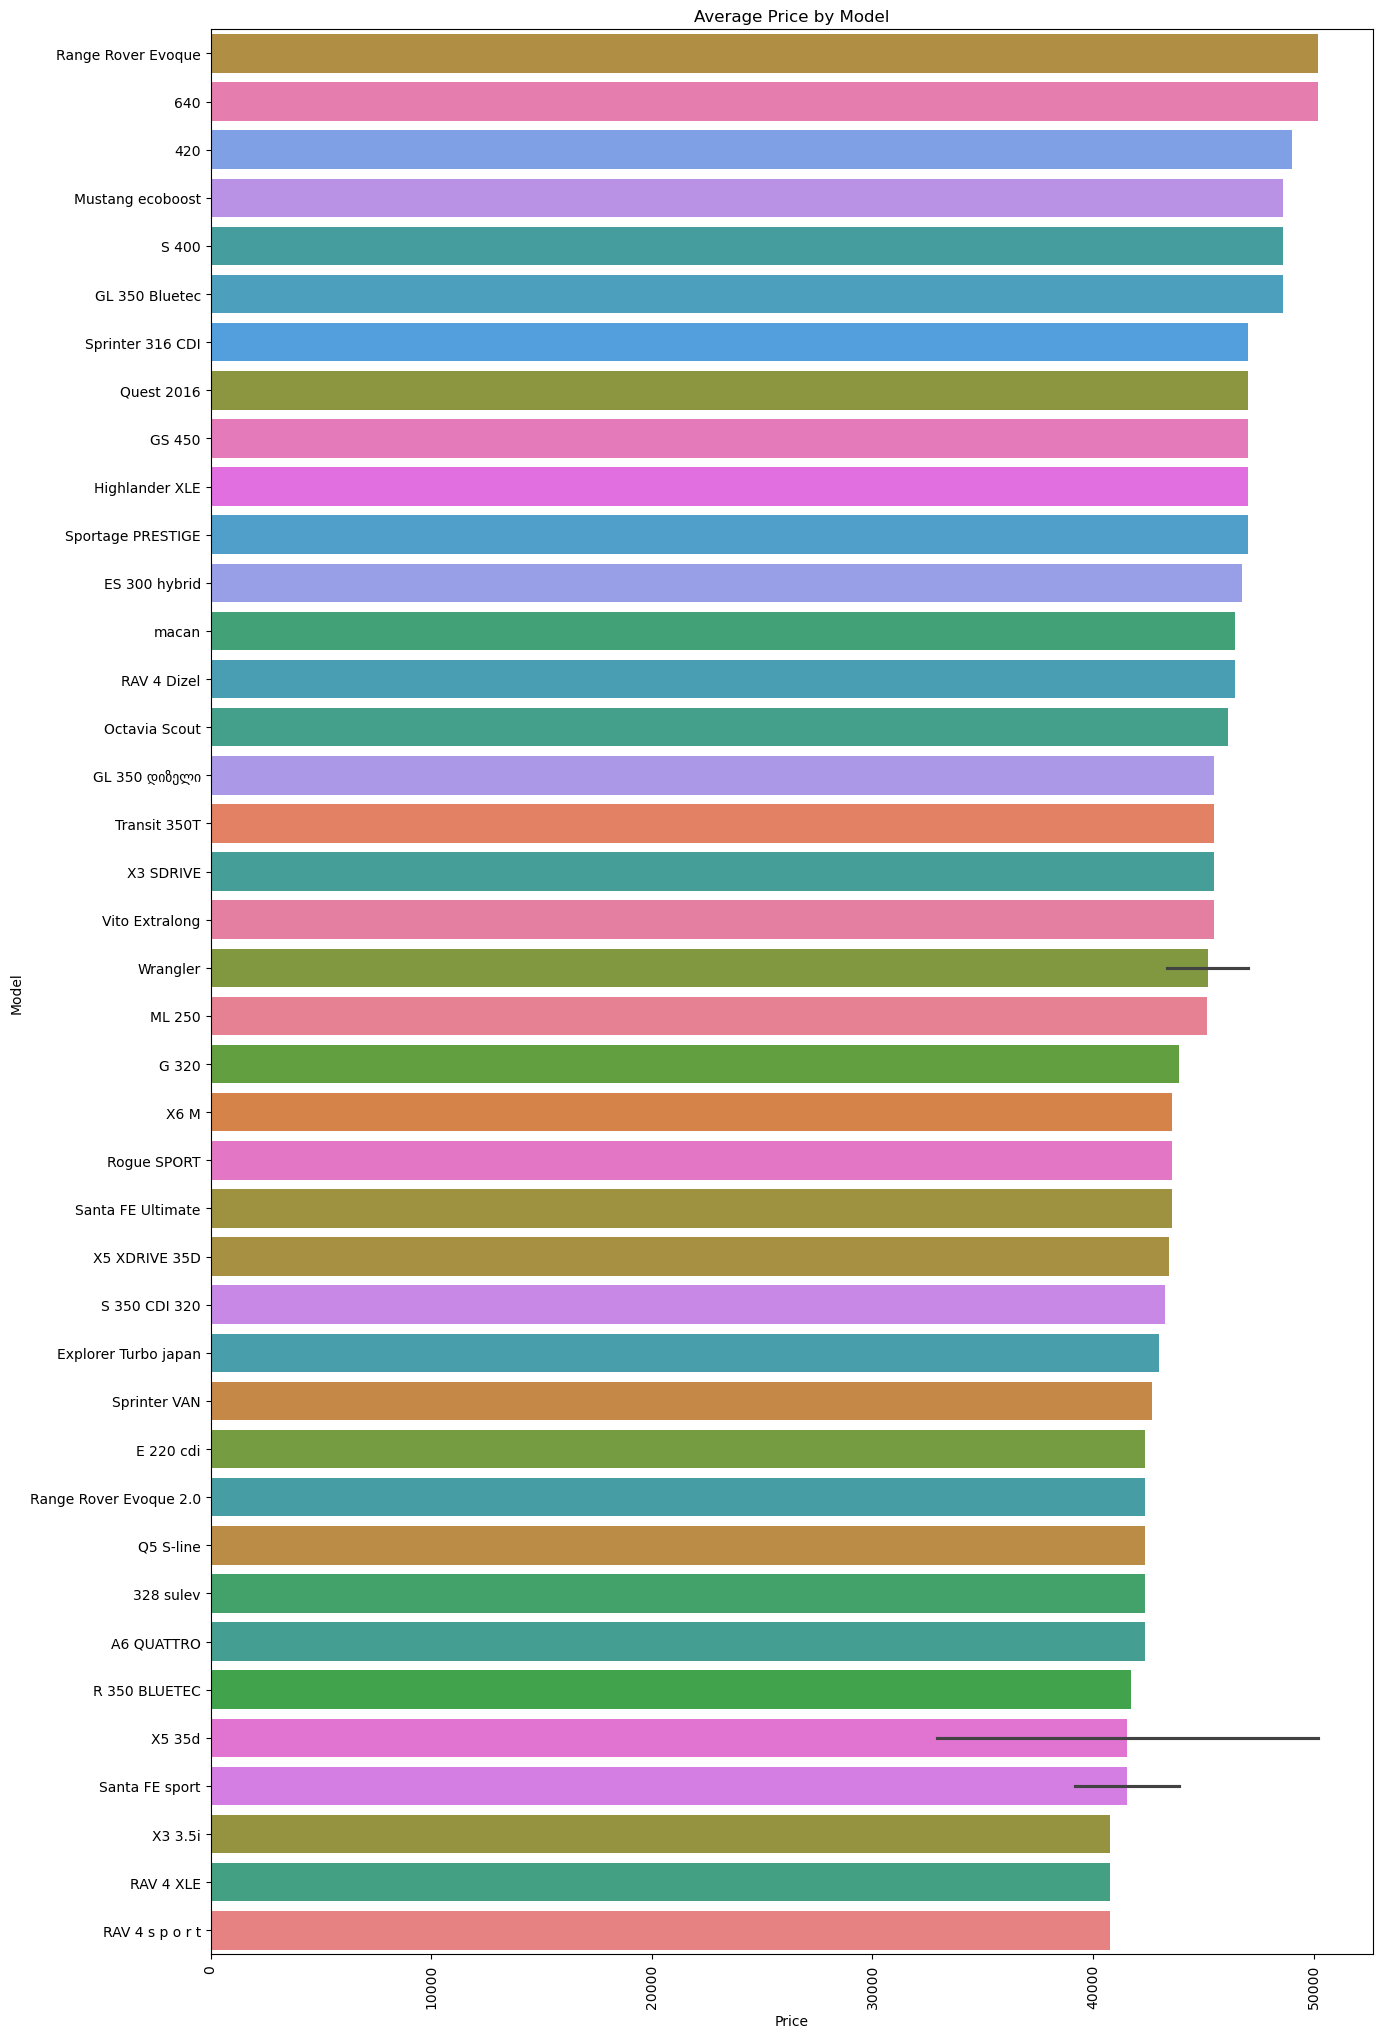

In [39]:
grouped_df = df.groupby('Model')['Price'].mean()
sorted_order = grouped_df.sort_values(ascending=False).index

df_subset = df[df['Model'].isin(sorted_order[:40])]

# Plotting
plt.figure(figsize=(15,25))  # Adjust the figure size as needed
sns.barplot(y='Model', x='Price', data=df_subset, estimator=np.mean, order=sorted_order[:40], hue='Model')
plt.title('Average Price by Model')
plt.xticks(rotation=90)
plt.show();

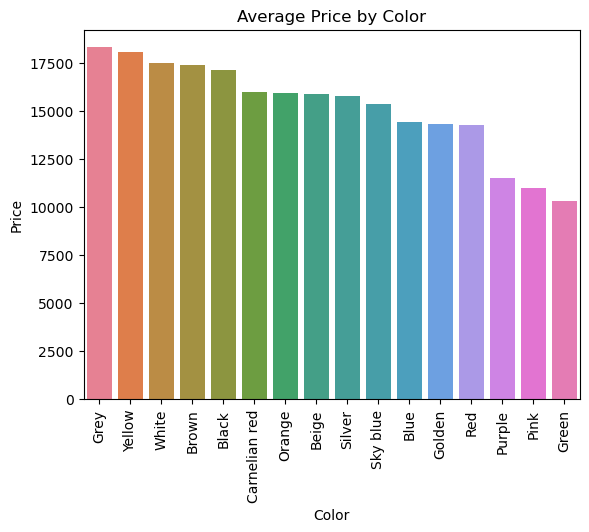

In [40]:
grouped_df = df.groupby('Color')['Price'].mean()
sorted_df = grouped_df.sort_values(ascending=False).reset_index()
 
sns.barplot(x='Color', y='Price', data=sorted_df, estimator="mean", hue='Color')
plt.title('Average Price by Color')
plt.xticks(rotation=90)
plt.show();

##### This shows that there is a probability that a silver car would be more expensive

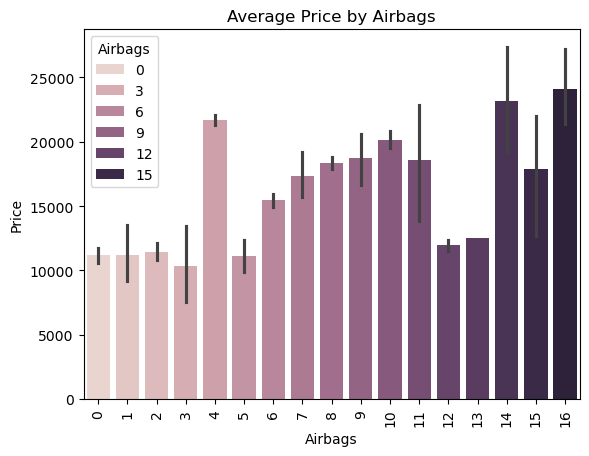

In [41]:
sns.barplot(x='Airbags', y='Price', data=df, estimator=np.mean, hue='Airbags')
plt.title('Average Price by Airbags')
plt.xticks(rotation=90);
plt.show()

##### In the no of airbags, there is a small impact in the number of airbags to the price

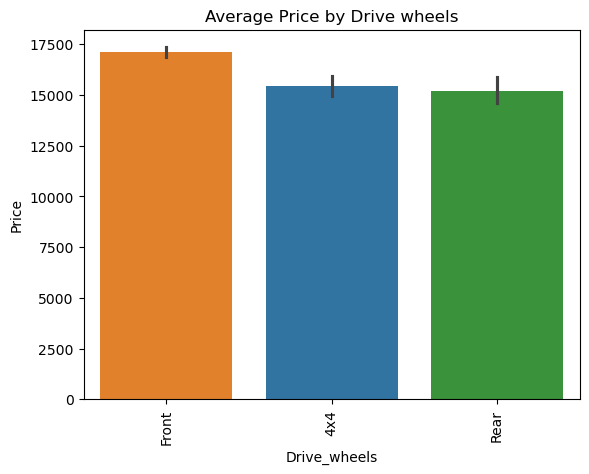

In [42]:
grouped_df = df.groupby('Drive_wheels')['Price'].mean()
sorted_order = grouped_df.sort_values(ascending=False).index
sns.barplot(x='Drive_wheels', y='Price', data=df, estimator=np.mean, hue='Drive_wheels', order=sorted_order)
plt.title('Average Price by Drive wheels')
plt.xticks(rotation=90)
plt.show();

##### Mean price for a front wheel is higher compared to the others

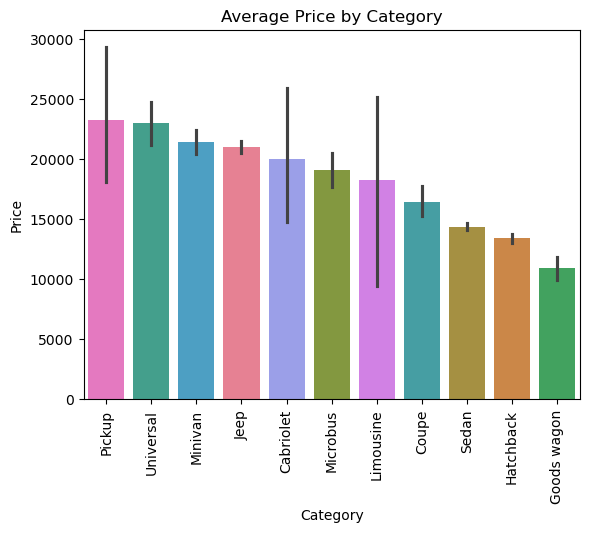

In [43]:
subset_df = df.iloc[:30]
grouped_df = df.groupby('Category')['Price'].mean()
sorted_order = grouped_df.sort_values(ascending=False).index

sns.barplot(data=df, x='Category', y='Price', estimator=np.mean, hue="Category", order=sorted_order)
plt.title('Average Price by Category')
plt.xticks(rotation=90);
plt.show();

##### The category has influence on the price

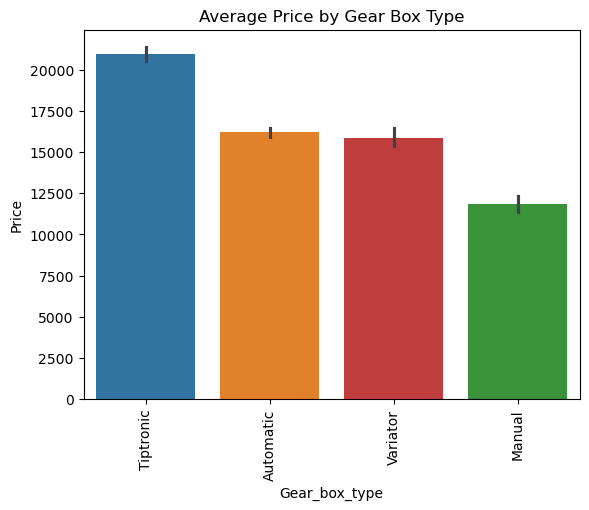

In [44]:
grouped_df = df.groupby('Gear_box_type')['Price'].mean()
sorted_order = grouped_df.sort_values(ascending=False).index

sns.barplot(data=df, x='Gear_box_type', y='Price', estimator=np.mean, hue="Gear_box_type", order=sorted_order)
plt.title('Average Price by Gear Box Type')
plt.xticks(rotation=90);
plt.show();

In [45]:
df

,Price,Levy,Manufacturer,Model,Prod._year,Category,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box_type,Drive_wheels,Color,Airbags
1,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3.0,192000,6,Tiptronic,4x4,Black,8
3,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966,4,Automatic,4x4,White,0
5,39493,891,HYUNDAI,Santa FE,2016,Jeep,Yes,Diesel,2.0,160931,4,Automatic,Front,White,4
6,1803,761,TOYOTA,Prius,2010,Hatchback,Yes,Hybrid,1.8,258909,4,Automatic,Front,White,12
7,549,751,HYUNDAI,Sonata,2013,Sedan,Yes,Petrol,2.4,216118,4,Automatic,Front,Grey,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19232,8467,906,MERCEDES-BENZ,CLK 200,1999,Coupe,Yes,CNG,2.0,300000,4,Manual,Rear,Silver,5
19233,15681,831,HYUNDAI,Sonata,2011,Sedan,Yes,Petrol,2.4,161600,4,Tiptronic,Front,Red,8
19234,26108,836,HYUNDAI,Tucson,2010,Jeep,Yes,Diesel,2.0,116365,4,Automatic,Front,Grey,4
19235,5331,1288,CHEVROLET,Captiva,2007,Jeep,Yes,Diesel,2.0,51258,4,Automatic,Front,Black,4


In [46]:
grouped_df = df.groupby(['Manufacturer'])['Model'].unique().apply(list).to_dict()
grouped_df
with open('../server/artifacts/manufactures_to_models.json', 'w') as file:
    json.dump(grouped_df, file, indent=4)



Let's visualize the relationship between two numerical variables. It is especially useful for identifying correlations, trends, clusters, and potential outliers in data

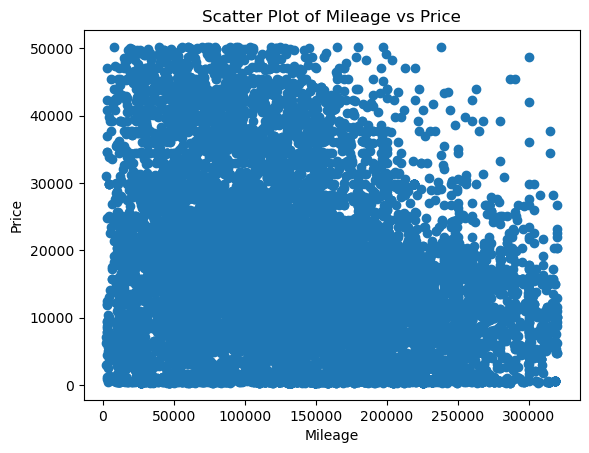

In [47]:
plt.scatter(x=df['Mileage'], y=df['Price'])
plt.xlabel('Mileage')
plt.ylabel('Price')
plt.title('Scatter Plot of Mileage vs Price')
plt.show();

I will be removing Manufacturing lesser than 2 here and come back to see the result

In [48]:
# man_counts = df['Manufacturer'].value_counts()

# # Filter out Models that appear less than 2 times
# df = df[df['Manufacturer'].isin(man_counts[man_counts >= 2].index)]
# df

In [49]:
# model_counts = df['Model'].value_counts()

# df = df[df['Model'].isin(model_counts[model_counts >=2 ].index)]
# df

#### FEATURE ENGINEERING

I want to explicity encode a notion of hgher value(mean) is equal to higher significance

In [50]:
df

,Price,Levy,Manufacturer,Model,Prod._year,Category,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box_type,Drive_wheels,Color,Airbags
1,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3.0,192000,6,Tiptronic,4x4,Black,8
3,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966,4,Automatic,4x4,White,0
5,39493,891,HYUNDAI,Santa FE,2016,Jeep,Yes,Diesel,2.0,160931,4,Automatic,Front,White,4
6,1803,761,TOYOTA,Prius,2010,Hatchback,Yes,Hybrid,1.8,258909,4,Automatic,Front,White,12
7,549,751,HYUNDAI,Sonata,2013,Sedan,Yes,Petrol,2.4,216118,4,Automatic,Front,Grey,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19232,8467,906,MERCEDES-BENZ,CLK 200,1999,Coupe,Yes,CNG,2.0,300000,4,Manual,Rear,Silver,5
19233,15681,831,HYUNDAI,Sonata,2011,Sedan,Yes,Petrol,2.4,161600,4,Tiptronic,Front,Red,8
19234,26108,836,HYUNDAI,Tucson,2010,Jeep,Yes,Diesel,2.0,116365,4,Automatic,Front,Grey,4
19235,5331,1288,CHEVROLET,Captiva,2007,Jeep,Yes,Diesel,2.0,51258,4,Automatic,Front,Black,4


In [51]:
def encoded_cols(cols_to_eng:list):
    for col in cols_to_eng:
        json_name = col+'s'
        mean_price = df.groupby(col)['Price'].mean()
        sorted_col = mean_price.sort_values(ascending=True)
        col_encoding = {column: value+1 for value, column in enumerate(sorted_col.index)}
        print(col_encoding)
        col_name = {json_name: col_encoding}

        with open(f'{col}.json', 'w') as file:
            json.dump(col_name, file, indent=4)

        df[col] = df[col].map(col_encoding)

In [52]:
cols_to_eng = ['Manufacturer', 'Model', 'Category', 'Gear_box_type', 'Fuel_type', 'Color', 'Drive_wheels']
encoded_cols(cols_to_eng)

{'ROVER': 1, 'DAIHATSU': 2, 'SEAT': 3, 'GMC': 4, 'UAZ': 5, 'VAZ': 6, 'PONTIAC': 7, 'DAEWOO': 8, 'OPEL': 9, 'SAAB': 10, 'GAZ': 11, 'MAZDA': 12, 'CADILLAC': 13, 'ACURA': 14, 'სხვა': 15, 'DODGE': 16, 'SUZUKI': 17, 'ALFA ROMEO': 18, 'GREATWALL': 19, 'ISUZU': 20, 'SUBARU': 21, 'CHRYSLER': 22, 'NISSAN': 23, 'VOLVO': 24, 'LEXUS': 25, 'PEUGEOT': 26, 'LANCIA': 27, 'RENAULT': 28, 'MERCURY': 29, 'PORSCHE': 30, 'VOLKSWAGEN': 31, 'CITROEN': 32, 'AUDI': 33, 'BUICK': 34, 'MITSUBISHI': 35, 'SATURN': 36, 'FIAT': 37, 'FORD': 38, 'HAVAL': 39, 'TOYOTA': 40, 'HONDA': 41, 'MERCEDES-BENZ': 42, 'CHEVROLET': 43, 'KIA': 44, 'SCION': 45, 'SKODA': 46, 'BMW': 47, 'MINI': 48, 'MASERATI': 49, 'HYUNDAI': 50, 'INFINITI': 51, 'JEEP': 52, 'HUMMER': 53, 'JAGUAR': 54, 'LAND ROVER': 55, 'LINCOLN': 56, 'SSANGYONG': 57}
{'B-MAX': 1, 'Serena Serea': 2, '535 M': 3, 'Panamera': 4, 'Crossland X': 5, 'Cooper S Cabrio': 6, 'GLE 450': 7, 'Sierra': 8, '24 10': 9, 'Eunos 500': 10, 'Space Runner': 11, 'HHR': 12, 'CLS 55 AMG': 13, 'Col

In [53]:
df

,Price,Levy,Manufacturer,Model,Prod._year,Category,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box_type,Drive_wheels,Color,Airbags
1,16621,1018,43,354,2011,8,No,4,3.0,192000,6,4,2,12,8
3,3607,862,38,424,2011,8,Yes,2,2.5,168966,4,3,2,14,0
5,39493,891,50,1069,2016,8,Yes,7,2.0,160931,4,3,3,14,4
6,1803,761,40,549,2010,2,Yes,2,1.8,258909,4,3,3,14,12
7,549,751,50,604,2013,3,Yes,4,2.4,216118,4,3,3,16,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19232,8467,906,42,234,1999,4,Yes,1,2.0,300000,4,1,1,8,5
19233,15681,831,50,604,2011,3,Yes,4,2.4,161600,4,4,3,4,8
19234,26108,836,50,1017,2010,8,Yes,7,2.0,116365,4,3,3,16,4
19235,5331,1288,43,703,2007,8,Yes,7,2.0,51258,4,3,3,12,4


In [54]:
df.isna().sum()

Price               0
Levy                0
Manufacturer        0
Model               0
Prod._year          0
Category            0
Leather_interior    0
Fuel_type           0
Engine_volume       0
Mileage             0
Cylinders           0
Gear_box_type       0
Drive_wheels        0
Color               0
Airbags             0
dtype: int64

##### Do the same feature engineering for the model col

In [55]:
"""STANDARDIZATION"""
scaler = StandardScaler()

scaled_data_mileage = scaler.fit_transform(df[['Mileage']])

df.loc[:,'Mileage'] = scaled_data_mileage

In [56]:
joblib.dump(scaler, 'mileage_scaler.pkl')

['mileage_scaler.pkl']

In [57]:
le = LabelEncoder()

In [58]:
df.loc[:, 'Leather_interior'] = le.fit_transform(df['Leather_interior'])

In [59]:
df.loc[:, 'Leather_interior'] = df['Leather_interior'].astype('category')

In [60]:
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype('category')

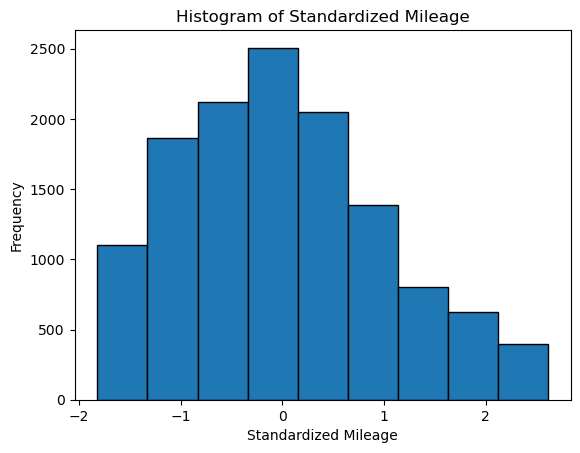

In [61]:
# plot a histogram to showcase the standardized values
plt.hist(df.Mileage, bins=9, edgecolor='black')
plt.xlabel('Standardized Mileage')
plt.ylabel('Frequency')
plt.title('Histogram of Standardized Mileage');
plt.show()

In [62]:
cleaned_df = df.copy()

In [63]:
cleaned_df

,Price,Levy,Manufacturer,Model,Prod._year,Category,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box_type,Drive_wheels,Color,Airbags
1,16621,1018,43,354,2011,8,0,4,3.0,0.828405,6,4,2,12,8
3,3607,862,38,424,2011,8,1,2,2.5,0.506801,4,3,2,14,0
5,39493,891,50,1069,2016,8,1,7,2.0,0.394615,4,3,3,14,4
6,1803,761,40,549,2010,2,1,2,1.8,1.762597,4,3,3,14,12
7,549,751,50,604,2013,3,1,4,2.4,1.165144,4,3,3,16,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19232,8467,906,42,234,1999,4,1,1,2.0,2.336315,4,1,1,8,5
19233,15681,831,50,604,2011,3,1,4,2.4,0.403956,4,4,3,4,8
19234,26108,836,50,1017,2010,8,1,7,2.0,-0.227621,4,3,3,16,4
19235,5331,1288,43,703,2007,8,1,7,2.0,-1.136653,4,3,3,12,4


In [64]:
"""TRAIN TEST SPLIT"""

'TRAIN TEST SPLIT'

In [65]:
X = cleaned_df.drop('Price', axis=1)
y = cleaned_df.Price

In [66]:
X

,Levy,Manufacturer,Model,Prod._year,Category,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box_type,Drive_wheels,Color,Airbags
1,1018,43,354,2011,8,0,4,3.0,0.828405,6,4,2,12,8
3,862,38,424,2011,8,1,2,2.5,0.506801,4,3,2,14,0
5,891,50,1069,2016,8,1,7,2.0,0.394615,4,3,3,14,4
6,761,40,549,2010,2,1,2,1.8,1.762597,4,3,3,14,12
7,751,50,604,2013,3,1,4,2.4,1.165144,4,3,3,16,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19232,906,42,234,1999,4,1,1,2.0,2.336315,4,1,1,8,5
19233,831,50,604,2011,3,1,4,2.4,0.403956,4,4,3,4,8
19234,836,50,1017,2010,8,1,7,2.0,-0.227621,4,3,3,16,4
19235,1288,43,703,2007,8,1,7,2.0,-1.136653,4,3,3,12,4


In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [68]:
lr_model = LinearRegression(n_jobs=10)
lr_model.fit(X_train, y_train)

LinearRegression(n_jobs=10)

In [69]:
lr_model.score(X_test, y_test)

0.4514873937938262

In [70]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

In [71]:
def get_best_model(X,y):
    model_params = {
        'linear_regression': {
            'model': LinearRegression(),
            'params': {
                'n_jobs': [5,10]
            }
        },
        'random_forest_reg': {
            'model': RandomForestRegressor(),
            'params': {
                'max_depth': [150],
                'n_estimators': [300],
            }
        },
        'xgb_regressor': {
            'model': XGBRegressor(objective='reg:squarederror', enable_categorical=True),
            'params': {
                'n_estimators': [200]
            }
        }
    }
    scores = []
    for model_name, mp in model_params.items():
        gs = GridSearchCV(mp['model'], mp['params'], cv=cv, return_train_score=False)
        gs.fit(X, y)
        scores.append({
            'model_name': model_name,
            'best_params': gs.best_params_,
            'best_score': gs.best_score_
        })
    best_model = pd.DataFrame(scores, columns=['model_name', 'best_params', 'best_score'])
    return best_model

In [73]:
models = get_best_model(X_train, y_train)

In [74]:
models

,model_name,best_params,best_score
0,linear_regression,{'n_jobs': 5},0.443118
1,random_forest_reg,"{'max_depth': 150, 'n_estimators': 300}",0.807170
2,xgb_regressor,{'n_estimators': 200},0.796459


In [185]:
def train_test_cross_validate(model, X_train, y_train, X_test, y_test, cv):
    model.fit(X_train, y_train)
    model_score = model.score(X_test, y_test)
    
    # Train pred
    y_train_pred = model.predict(X_train)
    rmse_train = mean_absolute_error(y_train, y_train_pred)

    # Test Pred
    y_test_pred = model.predict(X_test)
    rmse_test = mean_absolute_error(y_test, y_test_pred)

    # Perform 5-fold cross-validation
    rmse_cv = -cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=cv)

    rmse_cv_mean = np.mean(rmse_cv)

    # Display results
    print(f'Model Score: {model_score:.4f}')
    print(f"Training RMSE: {rmse_train:.4f}")
    print()
    print(f"Initial Test RMSE: {rmse_test:.4f}")
    print()
    print(f"Average Cross-Validation RMSE: {rmse_cv_mean:.4f}")
    print()
    print(f"Cross-Validation Scores: {rmse_cv}\n")
    print()

In [186]:
additional_params = {
    'X_train' : X_train, 
    'y_train' : y_train, 
    'X_test' : X_test, 
    'y_test': y_test, 
    'cv':10}


models = {
    'Xgboost': XGBRegressor(n_estimators=150, enable_categorical=True),
    'Random Forest': RandomForestRegressor(max_depth=10, n_estimators=200),
}

for model_name, model in models.items():
    print(f'{model_name} Regression Model: ')
    print()

    trained_model = train_test_cross_validate(model, **additional_params)

    print(trained_model)

Xgboost Regression Model: 

Model Score: 0.8164
Training RMSE: 1803.7547

Initial Test RMSE: 3279.2142

Average Cross-Validation RMSE: 5287.2224

Cross-Validation Scores: [5014.46608951 4907.94120236 5719.64220832 5628.83543963 5083.68964109
 5212.51872722 5139.90875718 6023.41351736 5162.76798392 4979.0406216 ]


None
Random Forest Regression Model: 

Model Score: 0.7765
Training RMSE: 3185.9896

Initial Test RMSE: 3813.2689

Average Cross-Validation RMSE: 5672.5304

Cross-Validation Scores: [5481.64253574 5188.67614322 6034.47302322 6084.836113   5707.24642592
 5547.4682417  5422.12447559 6056.06886738 5795.65915674 5407.10901456]


None


In [187]:
model_xgb = XGBRegressor(n_estimators=150, enable_categorical=True)
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=150, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [188]:
model_xgb.score(X_test, y_test)

0.8164268136024475

In [189]:
model_rfr = RandomForestRegressor(n_estimators=100, max_depth=100)

In [190]:
model_rfr.fit(X_train, y_train)

RandomForestRegressor(max_depth=100)

In [191]:
model_rfr.score(X_test, y_test)

0.8169492410580844

In [192]:
# Dump the model
joblib.dump(model_rfr, 'model_rfr.pkl')

['model_rfr.pkl']

In [193]:
joblib.dump(model_xgb, 'model_xgb.pkl')

['model_xgb.pkl']

In [194]:
X.columns

Index(['Levy', 'Manufacturer', 'Model', 'Prod._year', 'Category',
       'Leather_interior', 'Fuel_type', 'Engine_volume', 'Mileage',
       'Cylinders', 'Gear_box_type', 'Drive_wheels', 'Color', 'Airbags'],
      dtype='object')

In [195]:
with open('Manufacturer.json', 'r') as file:
    manufacturers_dict = json.load(file)

with open('Model.json', 'r') as file:
    models_dict = json.load(file)

with open('Category.json', 'r') as file:
    categories_dict = json.load(file)

with open('Fuel_type.json', 'r') as file:
    fuel_types_dict = json.load(file)

with open('Gear_box_type.json', 'r') as file:
    gear_box_types_dict = json.load(file)

with open('Drive_wheels.json', 'r') as file:
    drive_wheels_dict = json.load(file)

with open('Color.json', 'r') as file:
    colors_dict = json.load(file)

In [196]:
X

,Levy,Manufacturer,Model,Prod._year,Category,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box_type,Drive_wheels,Color,Airbags
1,1018,43,354,2011,8,0,4,3.0,0.828405,6,4,2,12,8
3,862,38,424,2011,8,1,2,2.5,0.506801,4,3,2,14,0
5,891,50,1069,2016,8,1,7,2.0,0.394615,4,3,3,14,4
6,761,40,549,2010,2,1,2,1.8,1.762597,4,3,3,14,12
7,751,50,604,2013,3,1,4,2.4,1.165144,4,3,3,16,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19232,906,42,234,1999,4,1,1,2.0,2.336315,4,1,1,8,5
19233,831,50,604,2011,3,1,4,2.4,0.403956,4,4,3,4,8
19234,836,50,1017,2010,8,1,7,2.0,-0.227621,4,3,3,16,4
19235,1288,43,703,2007,8,1,7,2.0,-1.136653,4,3,3,12,4


In [197]:
def get_value_from_dict(value, dictionary, default_mean=True):
    """
    Helper function to get a value from a dictionary.
    If the value is not found, it returns the mean of the dictionary values.
    """
    value = value.title()
    result = dictionary.get(value, None)
    
    if result is None and default_mean:
        result = np.mean(list(dictionary.values()))
        
    return result

def predict_used_car_price(**kwargs):
    """Util function to predict the price of a used car."""
    
    mileage_scaler = joblib.load('mileage_scaler.pkl')
    x = np.zeros(len(X.columns))
    
    for key, value in kwargs.items():
        # value = value.title()
        
        if key == 'levy':
            x[0] = value
        
        elif key == 'manufacturer':
            x[1] = get_value_from_dict(value, manufacturers_dict['Manufacturers'])
        
        elif key == 'model':
            x[2] = get_value_from_dict(value, models_dict['Models'])
        
        elif key == 'prod_year':
            x[3] = value
        
        elif key == 'category':
            x[4] = get_value_from_dict(value, categories_dict['Categorys'])
        
        elif key == 'interior':
            x[5] = 1 if value == 'Leather' else 0
        
        elif key == 'fuel_type':
            x[6] = get_value_from_dict(value, fuel_types_dict['Fuel_types'])
        
        elif key == 'engine_volume':
            x[7] = value
        
        elif key == 'mileage':
            mileage_df = pd.DataFrame([[value]], columns=['Mileage'])
            x[8] = mileage_scaler.transform(mileage_df)[0][0]
        
        elif key == 'cylinder':
            x[9] = value
        
        elif key == 'gear_box_type':
            x[10] = get_value_from_dict(value, gear_box_types_dict['Gear_box_types'])
        
        elif key == 'drive_wheel':
            x[11] = get_value_from_dict(value, drive_wheels_dict['Drive_wheelss'])
        
        elif key == 'color':
            x[12] = get_value_from_dict(value, colors_dict['Colors'])
        
        elif key == 'airbag':
            x[13] = value
    
    x_df = pd.DataFrame([x], columns=X.columns)
    return model_xgb.predict(x_df)[0]
        


In [198]:
predict_used_car_price(
    levy=1234,
    manufacturer='HonDa', 
    model='Civic', 
    category='sedan',
    prod_year=2018, 
    fuel_type='Petrol', 
    color='Yellow', 
    engine_volume=3.5, 
    drive_wheel='4x4', 
    airbag=10, 
    cylinder=12, 
    mileage=145000, 
    interior='Leather')

45707.82

In [199]:
columns = {
    'data_columns': [col for col in X.columns]
}
with open('columns.json', 'w') as file:
    json.dump(columns, file, indent=4)